МІНІСТЕРСТВО ОСВІТИ І НАУКИ, МОЛОДІ ТА СПОРТУ УКРАЇНИ
НАЦІОНАЛЬНИЙ ТЕХНІЧНИЙ УНІВЕРСИТЕТ УКРАЇНИ
«КИЇВСЬКИЙ ПОЛІТИХНІЧНИЙ ІНСТИТУТ ІМ.ІГОРЯ СІКОРСЬКОГО»
ФІЗИКО-ТЕХНІЧНИЙ ІНСТИТУТ


Лабораторна робота №2
«Геометричні перетворення координат у просторі»
Варіант 9





Виконав:                                                                     Студент 2 курсу
     Групи ФІ-21
Климентьєв Максим




Київ 2024

In [121]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
%matplotlib widget

import numpy as np

from sympy import symbols, Eq, solve

import copy

# ЗАВДАННЯ ДО ЛАБОРАТОРНОЇ РОБОТИ

1. Ознайомитись з теоретичними відомостями до лабораторної роботи. Дослідити кожне перетворення (перетворення, масштабування, поворот, відображення тощо) та їхні комбінації просторі. Ознайомитись з матеріалом, який віднситься до проектування об’єктів на площину.

In [122]:
class Line:
    def __init__(self, point:list[float, float, float], vector:list[float, float, float]):
        self.point = np.array(point)
        self.vector = np.array(vector)
        
        self.vector = self.vector / np.sqrt(self.vector[0]**2 + self.vector[1]**2 + self.vector[2]**2)
        # print(type(self.vector), self.vector.shape, self.vector)
        self.vector_4d = np.concatenate((self.vector, np.array([1])))
        # print(type(self.vector), self.vector.shape, self.vector_4d)
        
        self.x = np.linspace(-5, 5)
        self.kx = (self.x - self.point[0])/self.vector[0] # self.x/self.vector[0] - self.point[0]/self.vector[0] 
        self.ky = self.vector[1]*self.kx + self.point[1]
        self.kz = self.vector[2]*self.kx + self.point[2]
    
    def find_all_matrix(self):
        # Move
        self.move_matrix = np.matrix([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [-self.point[0], -self.point[1], -self.point[2], 1],
        ])
        
        self.move_back_matrix = np.matrix([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [self.point[0], self.point[1], self.point[2], 1],
        ])
        
        # R_x
        self.cos_ksi =  self.vector[2]/np.sqrt(self.vector[0]**2 + self.vector[2]**2)
        self.sin_ksi =  self.vector[0]/np.sqrt(self.vector[0]**2 + self.vector[2]**2)
        
        self.matrix_x = np.matrix([
            [1, 0, 0, 0],
            [0, self.cos_ksi, self.sin_ksi, 0],
            [0, -self.sin_ksi, self.cos_ksi, 0],
            [0, 0, 0, 1],
        ])
        self.back_matrix_x = self.matrix_x.T
        
        
        # R_y
        self.new_vector = self.vector_4d * self.matrix_x

        self.cos_theta = self.new_vector[0, 2]
        self.sin_theta = self.new_vector[0, 0]

        self.matrix_y = np.matrix([
            [self.cos_theta, 0, self.sin_theta, 0],
            [0, 1, 0, 0],
            [-self.sin_theta, 0, self.cos_theta, 0],
            [0, 0, 0, 1],
        ])
        self.back_matrix_y = self.matrix_y.T
        
    def phi(self, phi):
        # R_z
        
        self.phi = phi
        self.cos_phi = np.cos(self.phi)
        self.sin_phi = np.sin(self.phi)
        
        self.matrix_z = np.matrix([
            [self.cos_phi, self.sin_phi, 0, 0],
            [-self.sin_phi, self.cos_phi, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1],
        ])
        self.back_matrix_z = self.matrix_z.T

In [123]:
class Space:
    def __init__(self, matrix_3x3:np.ndarray=True):
        if type(matrix_3x3) != bool:
            self.matrix = matrix_3x3
        else:
            self.matrix = np.random.randint(-6, 6, size=(3, 3))

        # print(self.matrix.shape, np.atleast_2d(self.matrix[:, 0]).T.shape)
        self.matrix = np.hstack((self.matrix, np.atleast_2d(self.matrix[:, 0]).T))
        # print(self.matrix)
        self.x = self.matrix[0]
        self.y = self.matrix[1]
        self.z = self.matrix[2]
        
        self.A = np.linalg.det(np.array([
            [self.y[1] - self.y[0], self.z[1] - self.z[0]],
            [self.y[2] - self.y[0], self.z[2] - self.z[0]]
        ]))
        self.B =  -np.linalg.det(np.array([
            [self.x[1] - self.x[0], self.z[1] - self.z[0]],
            [self.x[2] - self.x[0], self.z[2] - self.z[0]]
        ]))
        self.C = np.linalg.det(np.array([
            [self.x[1] - self.x[0], self.y[1] - self.y[0]],
            [self.x[2] - self.x[0], self.y[2] - self.y[0]]
        ]))
        self.D = -self.x[0]*self.A - self.y[0]*self.B - self.z[0]*self.C
        self.sqrt = np.sqrt(self.A**2 + self.B**2 + self.C**2)
        self.vector = np.array([self.A/self.sqrt, self.B/self.sqrt, self.C/self.sqrt])
        
        
        self.vector1 = self.matrix[1, :3] - self.matrix[0, :3]
        self.vector2 = self.matrix[2, :3] - self.matrix[0, :3]
        space_vector = np.cross(self.vector1, self.vector2)
        # print(self.vector == normal_vector)
        
        n = space_vector / np.linalg.norm(space_vector)
        z_normal = np.array([0, 0, 1])
        cos_theta = np.dot(n, z_normal) / (np.linalg.norm(n) * np.linalg.norm(z_normal))
        self.angle = np.arccos(cos_theta)
        # print(np.cos(self.angle))
        self.M1b = np.matrix([
            [np.cos(self.angle), 0, np.sin(self.angle), 0],
            [0, 1, 0, 0],
            [-np.sin(self.angle), 0, np.cos(self.angle), 0],
            [0, 0, 0, 1]
        ])
        self.M5b = self.M1b.T
        
        x0, x1 = min(self.x), max(self.x)
        y0, y1 = min(self.y), max(self.y)
        
        for X in np.arange(x0, x1, 0.2):
            for Y in np.arange(y0, y1, 0.2):
                try:
                    self.space = np.vstack((self.space, np.array([X, Y, -(self.A*X+self.B*Y+self.D)/self.C])))
                except AttributeError:
                    self.space = np.array([X, Y, -(self.A*X+self.B*Y+self.D)/self.C])
        
    def create_all_matrix(self):
        self.M1 = np.matrix([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [0, 0, self.D/self.C, 1]
        ])
        sqrt2 = np.sqrt(self.A**2 + self.B**2)
        self.M2 = np.matrix([
            [self.A/sqrt2, -self.B/sqrt2, 0, 0],
            [self.B/sqrt2, self.A/sqrt2, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ])
        self.M2a = self.M2.T
        self.M3 = np.matrix([
            [self.C/self.sqrt, 0, sqrt2/self.sqrt, 0],
            [0, 1, 0, 0],
            [-sqrt2/self.sqrt, 0, self.C/self.sqrt, 0],
            [0, 0, 0, 1]
        ])
        self.M3a = self.M3.T
        self.M4 = np.matrix([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, -1, 0],
            [0, 0, 0, 1]
        ])
        self.M5 = self.M3.T
        self.M5a = self.M3
        self.M6 = self.M2.T
        self.M6a = self.M2
        self.M7 = np.matrix([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [0, 0, -self.D/self.C, 1]
        ])
    
    def create_proection_matrix(self, z1):
        self.M2b = np.matrix([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, -z1],
            [0, 0, 0, 1]
        ])
        self.M3b = np.matrix([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 1]
        ])
        self.M4b = np.matrix([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, z1],
            [0, 0, 0, 1]
        ])
        

In [124]:
Space()

In [125]:
class Cube:
    def __init__(self, starting_point:list[float, float, float], cube_edge_len:float):
        # Задаємо координати вершин куба
        close_right_down = [starting_point[0], starting_point[1], starting_point[2]] #  [2, 2, -2]
        far_right_down = [starting_point[0] + cube_edge_len, starting_point[1], starting_point[2]] # [4, 2, -2]
        close_right_up = [starting_point[0], starting_point[1], starting_point[2] + cube_edge_len] # [2, 2, 0]
        far_right_up = [starting_point[0] + cube_edge_len, starting_point[1], starting_point[2] + cube_edge_len] # [4, 2, 0]
        close_left_down = [starting_point[0], starting_point[1] + cube_edge_len, starting_point[2]] # [2, 4, -2]
        far_left_down = [starting_point[0] + cube_edge_len, starting_point[1] + cube_edge_len, starting_point[2]] # [4, 4, -2]
        close_left_up = [starting_point[0], starting_point[1] + cube_edge_len, starting_point[2] + cube_edge_len] # [2, 4, 0]
        far_left_up = [starting_point[0] + cube_edge_len, starting_point[1] + cube_edge_len, starting_point[2] + cube_edge_len] # [4, 4, 0]
        
        self.array = np.array([
            close_right_down, #0
            close_right_up, #1
            close_left_up, #2
            close_left_down, #3
            far_right_down, #4
            far_right_up, #5
            far_left_up, #6
            far_left_down]) #7
        
        self.array_4d = np.column_stack((self.array, np.array([1]*self.array.shape[0])))
        
        self.system_coordinates = np.array([
            [[-10, -abs(starting_point[0])+abs(+cube_edge_len)][abs(starting_point[0])+abs(+cube_edge_len)>=10], 0, 0],
            [[10, abs(starting_point[0])+abs(+cube_edge_len)][abs(starting_point[0])+abs(+cube_edge_len)>=10], 0, 0],
            [0, [-10, -abs(starting_point[0])+abs(+cube_edge_len)][abs(starting_point[1])+abs(+cube_edge_len)>=10], 0],
            [0, [10, abs(starting_point[0])+abs(+cube_edge_len)][abs(starting_point[1])+abs(+cube_edge_len)>=10], 0],
            [0, 0, [-10, -abs(starting_point[0])+abs(+cube_edge_len)][abs(starting_point[2])+abs(+cube_edge_len)>=10]],
            [0, 0, [10, abs(starting_point[0])+abs(+cube_edge_len)][abs(starting_point[2])+abs(+cube_edge_len)>=10]]])
    
    def update_array(self):
        self.array = np.array(self.array_4d[:, :3])
        
    def update_array_4d(self):
        self.array_4d = np.column_stack((self.array, np.array([1]*self.array.shape[0])))

    def multiple(self, matrix:np.matrix):
        self.array_4d = self.array_4d * matrix
        self.update_array()
    
    # Scaling
    def scale(self, num):
        if type(num) == int or type(num) == float:
            self.multiple(np.matrix([
                [num, 0, 0, 0],
                [0, num, 0, 0],
                [0, 0, num, 0],
                [0, 0, 0, 1]
            ]))
        elif type(num) == list and len(num) == 3:
            self.multiple(np.matrix([
                [num[0], 0, 0, 0],
                [0, num[1], 0, 0],
                [0, 0, num[2], 0],
                [0, 0, 0, 1]
            ]))
    
    def rotate(self, line:Line, phi:np.radians):
        line.phi(phi)
        self.multiple(line.move_matrix)
        self.multiple(line.matrix_x)
        self.multiple(line.matrix_y)
        self.multiple(line.matrix_z)
        # self.multiple(line.back_matrix_z)
        self.multiple(line.back_matrix_y)
        self.multiple(line.back_matrix_x)
        self.multiple(line.move_back_matrix)
        
    def symetria_above_space(self, space:Space):
        self.multiple(space.M1)
        self.multiple(space.M2)
        self.multiple(space.M3)
        self.multiple(space.M4)
        self.multiple(space.M5)
        self.multiple(space.M6)
        self.multiple(space.M7)
        
    def symetria_above_space_other(self, space:Space):
        self.multiple(space.M1)
        self.multiple(space.M3)
        self.multiple(space.M2)
        self.multiple(space.M4)
        self.multiple(space.M6)
        self.multiple(space.M5)
        self.multiple(space.M7)
    
    def symetria_above_space_another(self, space:Space):
        self.update_array()

        for row_index in range(self.array.shape[0]):
            t = symbols('t')
            x, y, z = self.array[row_index, 0], self.array[row_index, 1], self.array[row_index, 2]
            # print(x, y, z, self.array[row_index])
            
            equation = Eq(space.A * (space.A * t + x) + space.B * (space.B * t + y) + space.C * (space.C * t + z) + space.D, 0)
            # print(equation)
            solution = solve(equation, t)
            
            x_o, y_o, z_o = space.A*solution[0]+x, space.B*solution[0]+y, space.C*solution[0]+z
            x_sym, y_sym, z_sym = 2*x_o-x, 2*y_o-y, 2*z_o-z

            self.array[row_index] = np.array([x_sym, y_sym, z_sym])
        self.update_array_4d()
    
    def proec(self, space:Space):
        corner1 = space.matrix[0, :3]
        corner2 = space.matrix[0, :3] + space.vector1
        corner3 = space.matrix[0, :3] + space.vector2
        corner4 = space.matrix[0, :3] + space.vector1 + space.vector2
        vertices = [corner1, corner2, corner4, corner3, corner1]
        vertices = [np.append(arr, 1) for arr in vertices]
        plane_moved_y = np.dot(vertices, space.M1b.T)
        z1 = plane_moved_y[0, 2]
        space.create_proection_matrix(z1)
        self.multiple(space.M1b)
        self.multiple(space.M2b)
        self.multiple(space.M3b)
        self.multiple(space.M4b)
        self.multiple(space.M5b)
    
    def create_faces(self):
        # Initialize a list of vertex coordinates for each face
        self.faces = [np.zeros([5,3])]*6
        # right face
        self.faces[0] = np.array([
            self.array[0], 
            self.array[1], 
            self.array[2], 
            self.array[3], 
            self.array[0], 
        ])
        # left face
        self.faces[1] = np.array([
            self.array[4],
            self.array[5],
            self.array[6],
            self.array[7],
            self.array[4],
        ])
        # back Face
        self.faces[2] = np.array([
            self.array[0],
            self.array[1],
            self.array[5],
            self.array[4],
            self.array[0],
        ])
        # front Face
        self.faces[3] = np.array([
            self.array[2],
            self.array[3],
            self.array[7],
            self.array[6],
            self.array[2],
        ])
        # top face
        self.faces[4] = np.array([
            self.array[5],
            self.array[6],
            self.array[2],
            self.array[1],
            self.array[5],
        ])
        # bottom face
        self.faces[5] = np.array([
            self.array[4],
            self.array[7],
            self.array[3],
            self.array[0],
            self.array[4],
        ])
    
    def plot3d(self, show_standart=False, line:Line=None, space:Space=None):
        self.create_faces()
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(self.array[:, 0], self.array[:, 1], self.array[:, 2])
        ax.plot(self.system_coordinates[:, 0][:2], self.system_coordinates[:, 1][:2], self.system_coordinates[:, 2][:2])
        ax.plot(self.system_coordinates[:, 0][2:4], self.system_coordinates[:, 1][2:4], self.system_coordinates[:, 2][2:4])
        ax.plot(self.system_coordinates[:, 0][4:6], self.system_coordinates[:, 1][4:6], self.system_coordinates[:, 2][4:6])
        
        if line != None:
            ax.plot(line.kx, line.ky, line.kz)
        
        if space != None:
            ax.plot(space.x, space.y, space.z, ".")
            ax.plot(space.space[:, 0], space.space[:, 1], space.space[:, 2])
        
        # plotting cube
        ax.add_collection3d(Poly3DCollection(self.faces, facecolors='cyan', linewidths=1, edgecolors='k', alpha=.25))
        if show_standart:
            ax.add_collection3d(Poly3DCollection(self.old_faces, facecolors='red', linewidths=1, edgecolors='k', alpha=.25))
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        
        plt.show()
        
    def copy(self):
        try:
            self.old_faces = self.faces.copy()
        except AttributeError:
            self.create_faces()
            self.old_faces = self.faces.copy()
        return copy.deepcopy(self)

2. Задати куб через його вершини. Здійснити масштабування куба (збільшення, зменшення у кілька разів). Записати відповідну матрицю.

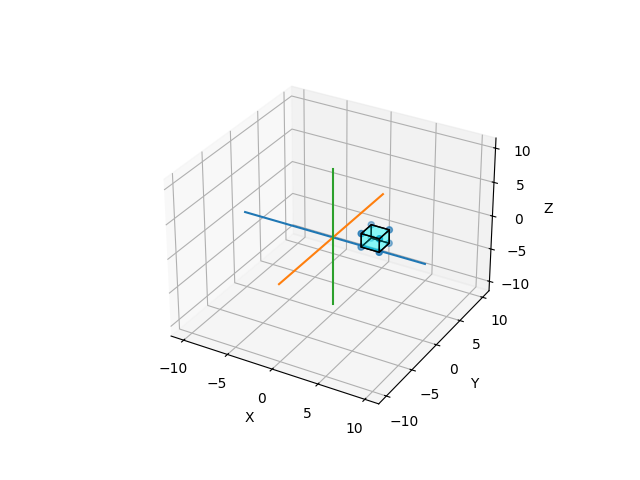

In [126]:
cube = Cube([2, 2, -2], 2)
cube.plot3d()

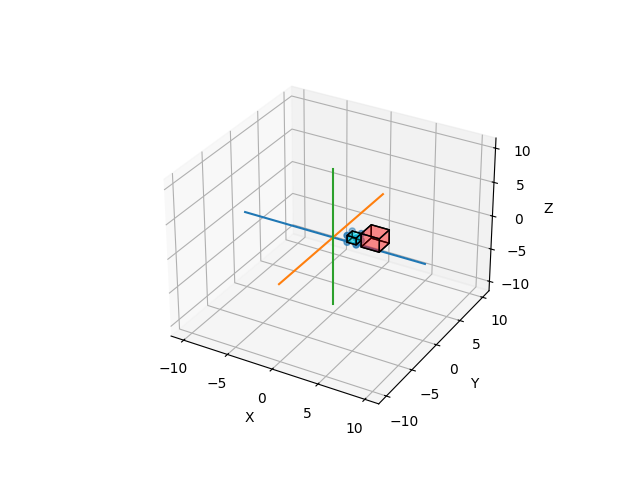

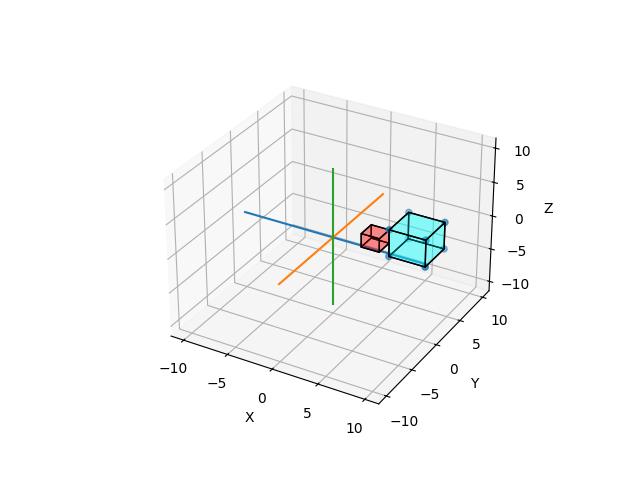

In [127]:
cube_scale_05 = cube.copy()
cube_scale_05.scale(0.5)
cube_scale_05.plot3d(True)

cube_scale_2 = cube.copy()
cube_scale_2.scale(2)
cube_scale_2.plot3d(True)

3. Отриманий результат з попереднього пункту симетрично відобразити відносно початку координат, відносно однієї з координатних площин у тривимірній декартовій системі координат (простір).

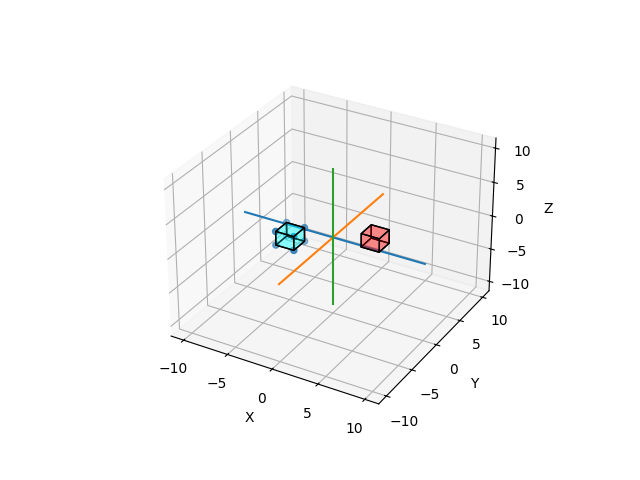

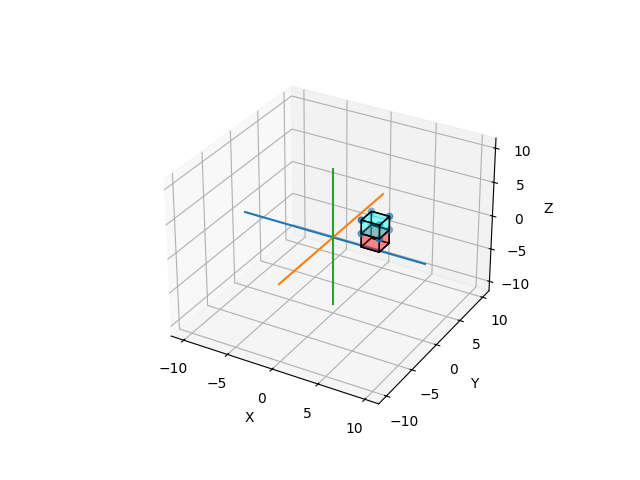

In [128]:
cube_xyz = cube.copy()
cube_xyz.scale([-1, -1, -1])
cube_xyz.plot3d(True)

cube_z = cube.copy()
cube_z.scale([1, 1, -1])
cube_z.plot3d(True)

4. Задати пряму як у прикладі 1 даної лабораторної роботи. Здійснити поворот куба відносно прямої на деякий кут φ. Вказати перетворення, які необхідні для одержання такого результату.

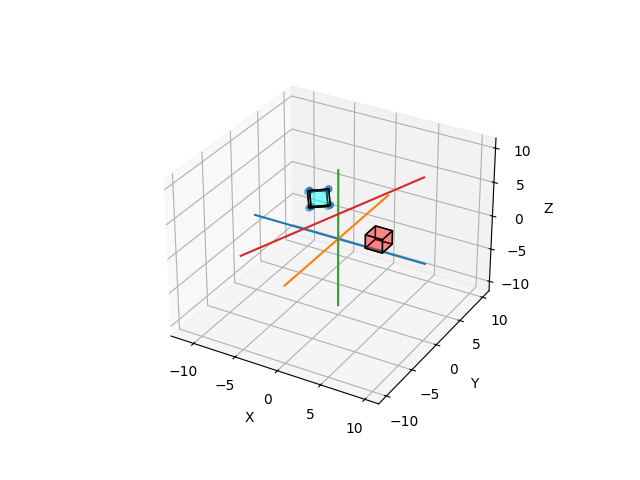

In [129]:
line = Line([1, 2, 3],[2, 1, 3])
line.find_all_matrix()
cube_rotate = cube.copy()
cube_rotate.rotate(line, np.pi)
cube_rotate.plot3d(True, line)

5. Задати площину, як у прикладі 2, здійснити симетрію куба відносно площини, вказати всі математичні перетворення, показати кінцевий результат, який відповідає вимогам задачі. Записати відповідні математичні перетворення.

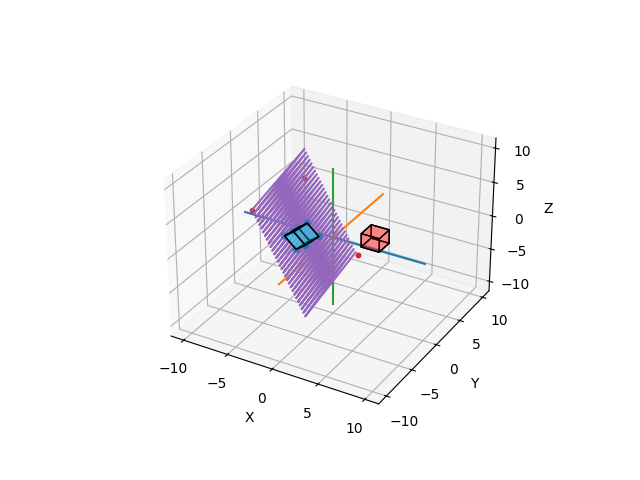

In [130]:
# space = Space(np.array([
#     [3, -4, 5],
#     [-4, 5, -6],
#     [1, -2, 3]
# ]))
space = Space()
space.create_all_matrix()
cube_space = cube.copy()
cube_space.symetria_above_space(space)
cube_space.plot3d(True, space=space)

6. (для студентів, які навчаються на кафедрі ММАД) Запропонувати інший набір перетворень для отримання результатів, які наведені у прикладі 2 даної лабораторної роботи. Тобто здійснити інші перетворення за загальним підходом (симетрія, поворот, перенесення), показати їх математично.

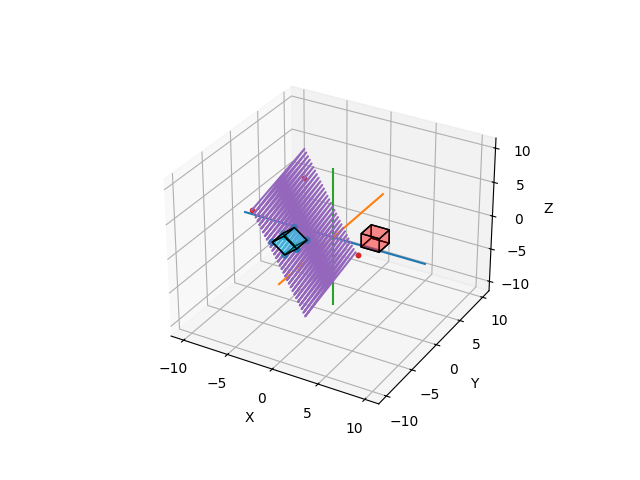

In [131]:
cube_space_other = cube.copy()
cube_space_other.symetria_above_space_other(space)
cube_space_other.plot3d(True, space=space)

8. (для студентів, які навчаються на кафедрі ММАД) Навести алгоритм з математичними перетвореннями для побудови симетрії відносно площини на основі знань з аналітичної геометрії. Порівняти результати (програмно)

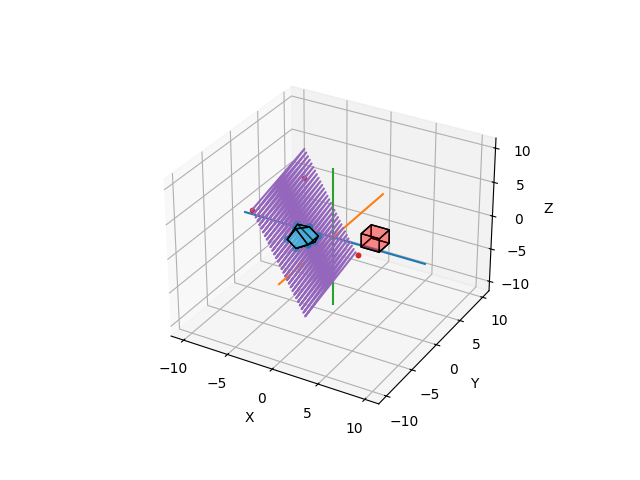

In [132]:
cube_space_another = cube.copy()
cube_space_another.symetria_above_space_another(space)
cube_space_another.plot3d(True, space=space)

10. (для всіх студентів) Взяти той самий куб, який був поданий у попередніх пунктах. Здійснити ортогональне проектування даного кубу на площину загального виду, яка не паралельна жодній з координатних площин. Вказати відповідні математичні перетворення, розробити відповідне програмне забезпечення.

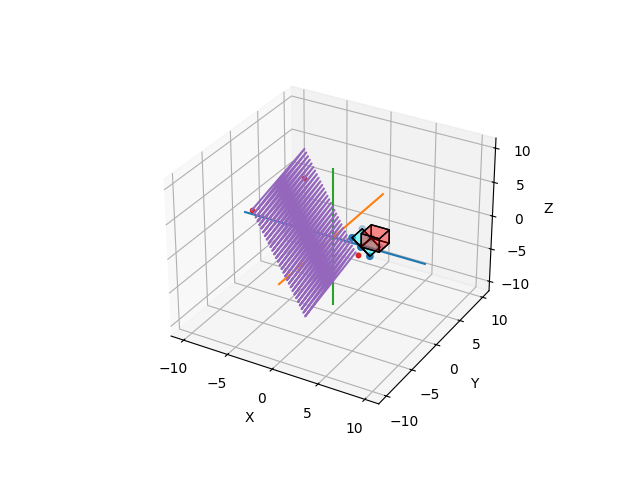

In [133]:
cube_proec = cube.copy()
cube_proec.proec(space)
cube_proec.plot3d(True, space=space)